This Project show detailed Preprocessing, EDA, Visualization and Modelling to predict horses that lived, died or euthanized

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

In [2]:
# sklearn and modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.impute import KNNImputer

In [3]:
sns.set()

# set max columns
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
orig_data = pd.read_csv('horse.csv')

In [5]:
print(train_df.shape, test_df.shape, orig_data.shape)

(1235, 29) (824, 28) (299, 28)


### Checking out the data

In [6]:
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)
train_df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,None,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [7]:
def change_None(df):
    cols = df.columns
    for col in cols:
        df[col] = df[col].replace({'None': np.nan})

In [8]:
change_None(train_df)
change_None(test_df)

In [9]:
# checking for Null Values
print(f'Null values (train): {train_df.isnull().any().any()}')
print(f'Null values (test): {test_df.isnull().any().any()}')
print(f'Null values (original data): {orig_data.isnull().any().any()}')

Null values (train): True
Null values (test): True
Null values (original data): True


In [10]:
cat_cols = list(train_df.select_dtypes('object').drop('outcome', axis=1).columns)
num_cols = list(train_df.select_dtypes(['int64', 'float64']).columns)
target = 'outcome'

### Visualization

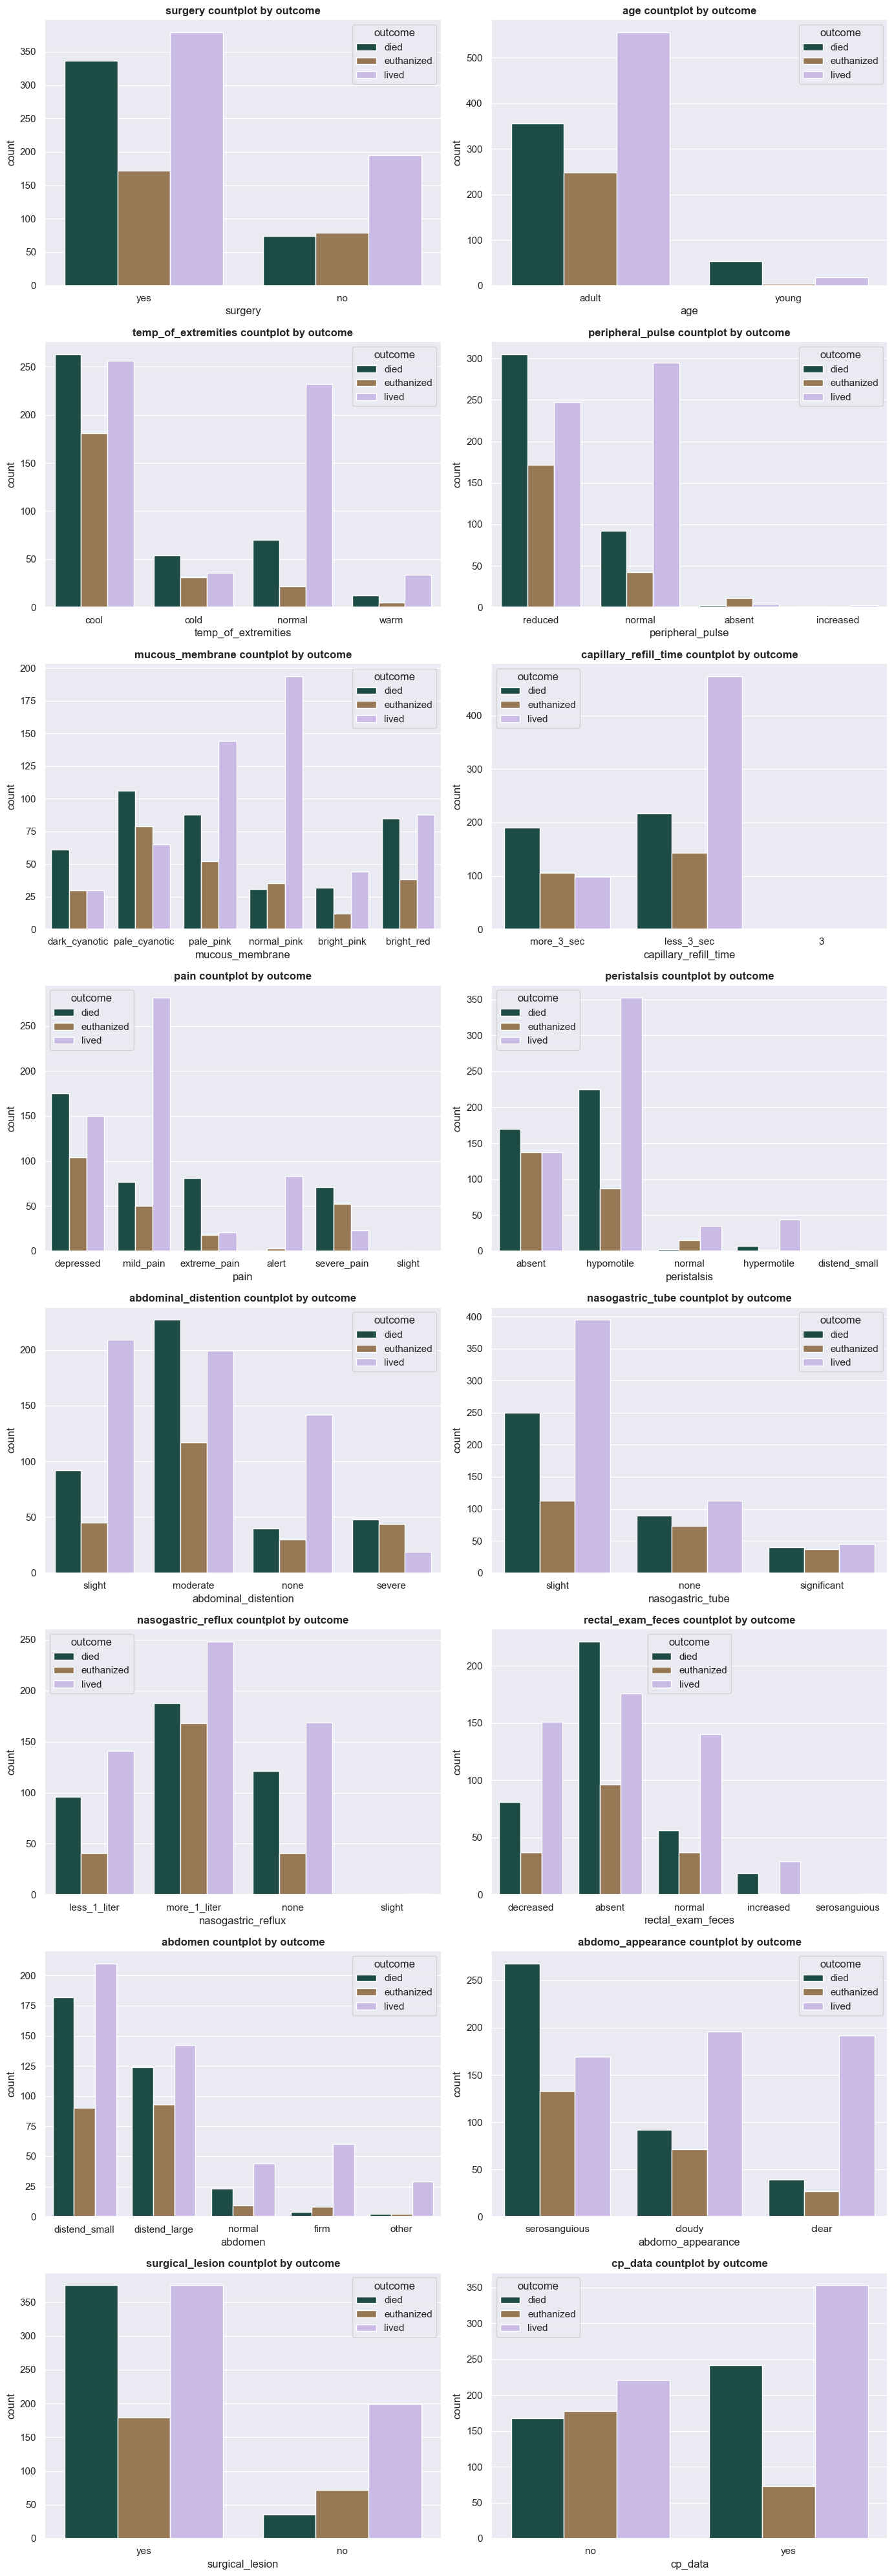

In [11]:
# figsize = width= 14, height = len(cat_col) * 2.5 i.e 40
# subplot(8,2,index +1) = 8 rows, 2, columns, index(position)
plt.figure(figsize=(14, round(len(cat_cols) * 2.5)))

for index, column in enumerate(cat_cols):
    plt.subplot(8,2,index+1)
    sns.countplot(x=column, hue='outcome', data=train_df, palette='cubehelix')
    plt.title(f'{column} countplot by outcome', fontweight='bold')
plt.tight_layout()

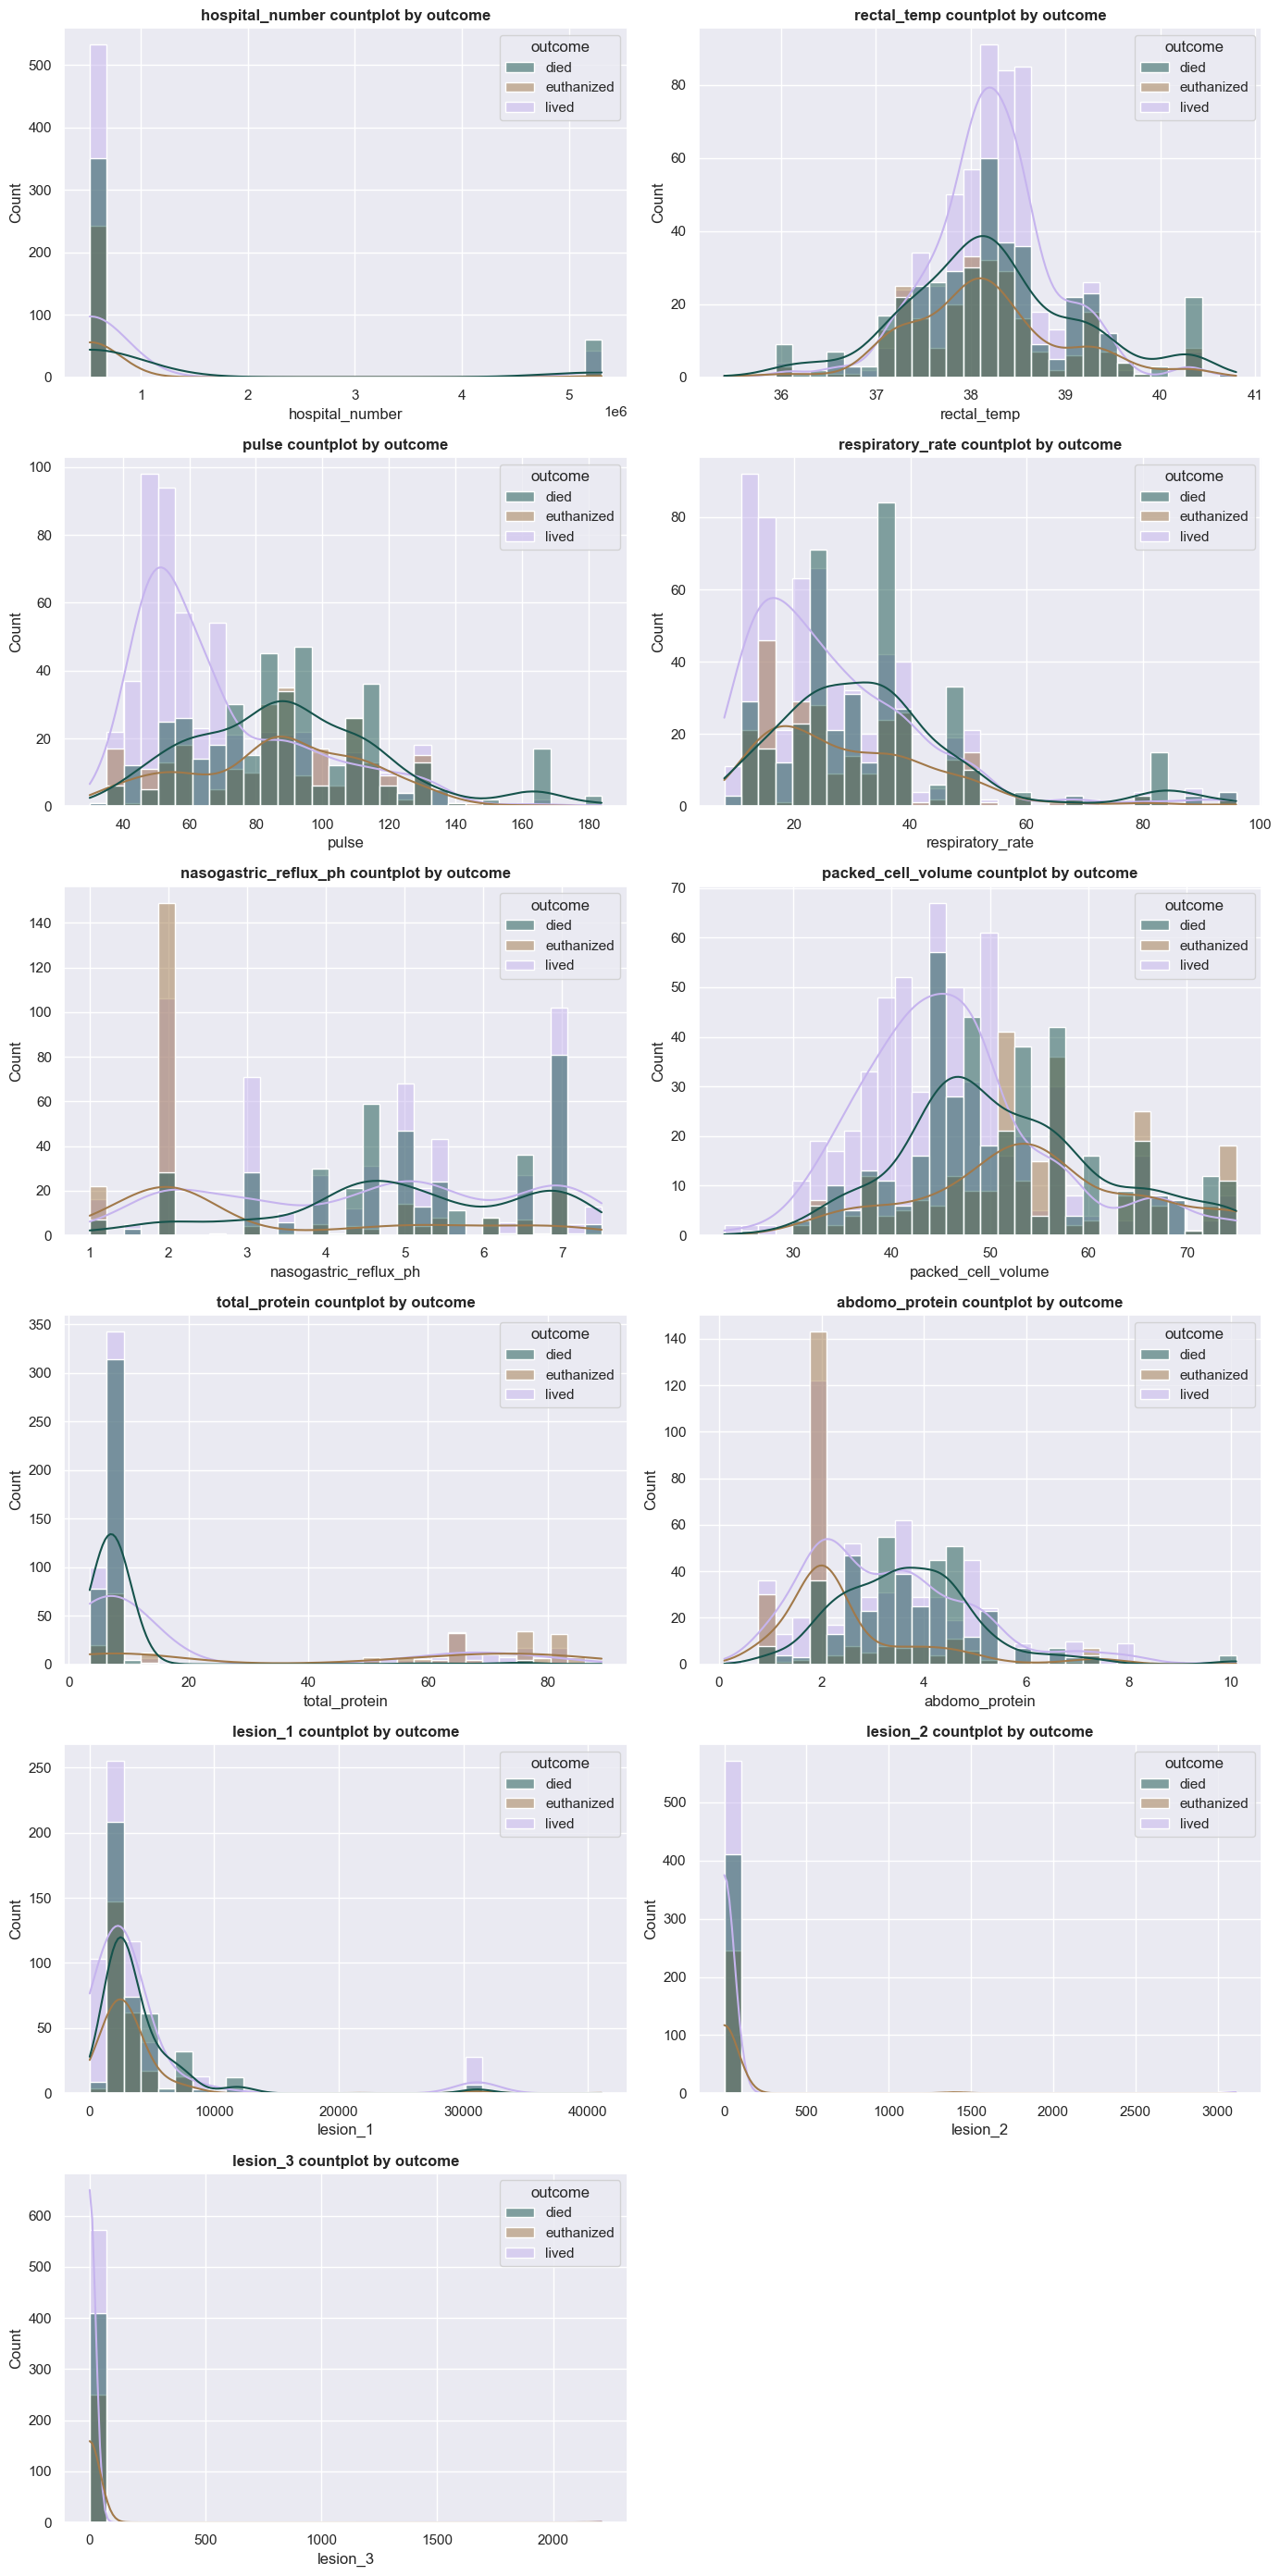

In [12]:
plt.figure(figsize=(14, round(len(num_cols) * 2.5)))

for index, column in enumerate(num_cols):
    plt.subplot(6,2,index+1)
    sns.histplot(x=column, bins=30, hue='outcome',kde=True, data=train_df, palette='cubehelix')
    plt.title(f'{column} countplot by outcome', fontweight='bold')
plt.tight_layout()

## Data Cleaning

In [13]:
train_df

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,more_3_sec,depressed,absent,moderate,none,more_1_liter,2.0,NaN,distend_large,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,decreased,distend_small,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,increased,firm,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,less_3_sec,mild_pain,hypomotile,slight,none,more_1_liter,2.0,absent,distend_small,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


**Encoding columns with 2 values**

In [14]:
for i in cat_cols:
    print(f'{i}: {train_df[i].nunique()}')

surgery: 2
age: 2
temp_of_extremities: 4
peripheral_pulse: 4
mucous_membrane: 6
capillary_refill_time: 3
pain: 6
peristalsis: 5
abdominal_distention: 4
nasogastric_tube: 3
nasogastric_reflux: 4
rectal_exam_feces: 5
abdomen: 5
abdomo_appearance: 3
surgical_lesion: 2
cp_data: 2


In [15]:
le_cols = ['surgery', 'age', 'surgical_lesion', 'cp_data']

In [16]:
encoder = LabelEncoder()

In [17]:
def apply_le(df, le_cols):    
    for col in le_cols:
        df[col] = encoder.fit_transform(df[col])
    return df

In [18]:
train_df = apply_le(train_df, le_cols)
test_df = apply_le(test_df, le_cols)
orig_data = apply_le(orig_data, le_cols)

In [19]:
train_df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,1,0,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,1,2209,0,0,0,died
1,1,0,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,1,2208,0,0,0,euthanized
2,1,0,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,1,5124,0,0,0,lived
3,1,0,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,1,2208,0,0,1,lived
4,0,0,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,0,0,0,0,1,lived


In [20]:
def value_count(col):
    print(f"{train_df[col].value_counts()}\n\n {test_df[col].value_counts()}\n\n {orig_data[col].value_counts()}\n")
    print(f'train: {train_df[col].isnull().sum()}')
    print(f'test: {test_df[col].isnull().sum()}')
    print(f'orig_data: {orig_data[col].isnull().sum()}')

def apply_replace(col, dic):
    train_df[col] = train_df[col].replace(dic)
    test_df[col] = test_df[col].replace(dic)
    orig_data[col] = orig_data[col].replace(dic)

    
def fill_map(col, fill, maps):
    train_df[col] = train_df[col].fillna(fill).map(maps)
    test_df[col] = test_df[col].fillna(fill).map(maps)
    orig_data[col] = orig_data[col].fillna(fill).map(maps)

**pain**

In [21]:
value_count('pain')

depressed       429
mild_pain       408
severe_pain     146
extreme_pain    120
alert            87
slight            1
Name: pain, dtype: int64

 depressed       310
mild_pain       255
severe_pain     115
extreme_pain     82
alert            32
moderate          1
Name: pain, dtype: int64

 mild_pain       67
depressed       59
extreme_pain    42
severe_pain     38
alert           38
Name: pain, dtype: int64

train: 44
test: 29
orig_data: 55


In [22]:
apply_replace('pain', {'slight': 'moderate'})

dic = {'alert': 0, 'depressed': 1, 'extreme_pain': 2, 'mild_pain': 3, 'severe_pain': 4, 'moderate': 5}
fill_map('pain', 'depressed', dic)

**temp_of_extremities**

In [23]:
value_count('temp_of_extremities')

cool      700
normal    324
cold      121
warm       51
Name: temp_of_extremities, dtype: int64

 cool      472
normal    198
cold       86
warm       33
Name: temp_of_extremities, dtype: int64

 cool      108
normal     78
warm       30
cold       27
Name: temp_of_extremities, dtype: int64

train: 39
test: 35
orig_data: 56


In [24]:
dic = {'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3}
fill_map('temp_of_extremities', 'normal', dic)

**peripheral_pulse**

In [25]:
value_count('peripheral_pulse')

reduced      724
normal       429
absent        18
increased      4
Name: peripheral_pulse, dtype: int64

 reduced      478
normal       285
absent        10
increased      4
Name: peripheral_pulse, dtype: int64

 normal       114
reduced      103
absent         8
increased      5
Name: peripheral_pulse, dtype: int64

train: 60
test: 47
orig_data: 69


In [26]:
dic = {'absent': 0, 'increased': 1, 'normal': 2, 'reduced': 3}
fill_map('peripheral_pulse', 'normal', dic)

**mucous_membrane**

In [27]:
value_count('mucous_membrane')

pale_pink        284
normal_pink      260
pale_cyanotic    250
bright_red       211
dark_cyanotic    121
bright_pink       88
Name: mucous_membrane, dtype: int64

 pale_cyanotic    212
pale_pink        165
normal_pink      161
bright_red       130
dark_cyanotic     80
bright_pink       63
Name: mucous_membrane, dtype: int64

 normal_pink      79
pale_pink        57
pale_cyanotic    41
bright_pink      30
bright_red       25
dark_cyanotic    20
Name: mucous_membrane, dtype: int64

train: 21
test: 13
orig_data: 47


In [28]:
dic = {'bright_pink': 0, 'bright_red': 1, 'dark_cyanotic': 2, 'normal_pink': 3, 'pale_cyanotic': 4, 'pale_pink': 5}
fill_map('mucous_membrane', 'pale_cyanotic', dic)

**capillary_refill_time**

In [29]:
value_count('capillary_refill_time')

less_3_sec    834
more_3_sec    393
3               2
Name: capillary_refill_time, dtype: int64

 less_3_sec    524
more_3_sec    290
3               4
Name: capillary_refill_time, dtype: int64

 less_3_sec    187
more_3_sec     78
3               2
Name: capillary_refill_time, dtype: int64

train: 6
test: 6
orig_data: 32


In [30]:
dic = {'less_3_sec': 0, 'more_3_sec': 1, '3': 2}
fill_map('capillary_refill_time', '3', dic)

**peristalsis**

In [31]:
value_count('peristalsis')

hypomotile       664
absent           444
normal            53
hypermotile       53
distend_small      1
Name: peristalsis, dtype: int64

 hypomotile     447
absent         297
hypermotile     39
normal          22
Name: peristalsis, dtype: int64

 hypomotile     127
absent          73
hypermotile     39
normal          16
Name: peristalsis, dtype: int64

train: 20
test: 19
orig_data: 44


In [32]:
apply_replace('peristalsis', {'distend_small': 'normal'})

dic = {'absent': 0, 'hypermotile': 1, 'hypomotile': 2, 'normal': 3}
fill_map('peristalsis', 'hypomotile', dic)

**abdominal_distention**

In [33]:
value_count('abdominal_distention')

moderate    543
slight      346
none        212
severe      111
Name: abdominal_distention, dtype: int64

 moderate    329
slight      255
none        151
severe       67
Name: abdominal_distention, dtype: int64

 none        75
slight      65
moderate    65
severe      38
Name: abdominal_distention, dtype: int64

train: 23
test: 22
orig_data: 56


In [34]:
dic = {'moderate': 0, 'none': 1, 'slight': 2, 'severe': 3}
fill_map('abdominal_distention', 'moderate', dic)

**nasogastric_tube**

In [35]:
value_count('nasogastric_tube')

slight         758
none           275
significant    122
Name: nasogastric_tube, dtype: int64

 slight         520
none           165
significant     75
Name: nasogastric_tube, dtype: int64

 slight         101
none            71
significant     23
Name: nasogastric_tube, dtype: int64

train: 80
test: 64
orig_data: 104


In [36]:
dic = {'none': 0, 'slight': 1, 'significant': 2}
fill_map('nasogastric_tube', 'none', dic)

**nasogastric_reflux**

In [37]:
value_count('nasogastric_reflux')

more_1_liter    604
none            331
less_1_liter    278
slight            1
Name: nasogastric_reflux, dtype: int64

 more_1_liter    373
none            225
less_1_liter    212
Name: nasogastric_reflux, dtype: int64

 none            119
more_1_liter     39
less_1_liter     35
Name: nasogastric_reflux, dtype: int64

train: 21
test: 14
orig_data: 106


In [38]:
apply_replace('nasogastric_reflux', {'slight': 'less_1_liter'})

dic = {'less_1_liter': 0, 'more_1_liter': 1, 'none': 2}
fill_map('nasogastric_reflux', 'more_1_liter', dic)

**rectal_exam_feces**

In [39]:
value_count('rectal_exam_feces')

absent           493
decreased        269
normal           233
increased         49
serosanguious      1
Name: rectal_exam_feces, dtype: int64

 absent       337
decreased    174
normal       157
increased     31
Name: rectal_exam_feces, dtype: int64

 absent       79
normal       57
decreased    48
increased    13
Name: rectal_exam_feces, dtype: int64

train: 190
test: 125
orig_data: 102


In [40]:
apply_replace('rectal_exam_feces', {'serosanguious': 'absent'})

dic = {'absent': 0, 'decreased': 1, 'increased': 2, 'normal': 3}
fill_map('rectal_exam_feces', 'absent', dic)

**abdomen**

In [41]:
value_count('abdomen')

distend_small    482
distend_large    359
normal            76
firm              72
other             33
Name: abdomen, dtype: int64

 distend_small    314
distend_large    240
firm              50
normal            34
other             32
Name: abdomen, dtype: int64

 distend_large    78
distend_small    43
normal           28
other            19
firm             13
Name: abdomen, dtype: int64

train: 213
test: 154
orig_data: 118


In [42]:
dic = {'distend_large': 0, 'distend_small': 1, 'firm': 2, 'normal': 3, 'other': 4}
fill_map('abdomen', 'distend_small', dic)

**abdomo_appearance**

In [43]:
value_count('abdomo_appearance')

serosanguious    570
cloudy           359
clear            258
Name: abdomo_appearance, dtype: int64

 serosanguious    387
cloudy           231
clear            175
Name: abdomo_appearance, dtype: int64

 cloudy           47
serosanguious    46
clear            41
Name: abdomo_appearance, dtype: int64

train: 48
test: 31
orig_data: 165


In [44]:
dic = {'clear': 0, 'cloudy': 1, 'serosanguious': 2}
fill_map('abdomo_appearance', 'serosanguious', dic)

**lesion_2**

In [45]:
train_df['lesion_2'] = train_df['lesion_2'].apply(lambda x:1 if x>1 else 0)
test_df['lesion_2'] = train_df['lesion_2'].apply(lambda x:1 if x>1 else 0)
orig_data['lesion_2'] = orig_data['lesion_2'].apply(lambda x:1 if x>1 else 0)

In [46]:
train_df['rectal_temp'] = (train_df['rectal_temp']-37.8).abs()
test_df['rectal_temp'] = (test_df['rectal_temp']-37.8).abs()
orig_data['rectal_temp'] = (orig_data['rectal_temp']-37.8).abs()

**merging the whole data**

In [47]:
print(train_df.shape)
print(orig_data.shape)

(1235, 28)
(299, 28)


In [48]:
df = pd.concat([train_df, orig_data])

In [49]:
df.drop_duplicates(inplace=True)

**numerical preprocessing**

In [50]:
imputer = KNNImputer(n_neighbors=12)

In [51]:
num_feat = pd.DataFrame(imputer.fit_transform(df[num_cols]), columns=num_cols)
test_num_feat = pd.DataFrame(imputer.fit_transform(test_df[num_cols]), columns=num_cols)

In [52]:
df = df.drop(num_cols, axis=1).reset_index(drop=True)
test_df = test_df.drop(num_cols, axis=1).reset_index(drop=True)

In [53]:
df = pd.concat([df, num_feat], axis=1)
test = pd.concat([test_df,test_num_feat], axis=1)

In [54]:
df.drop('lesion_3', axis=1, inplace=True)
test.drop('lesion_3', axis=1, inplace=True)

In [55]:
print(f'Null values(train): {df.isnull().any().any()}')
print(f'Null values(test): {test.isnull().any().any()}')

Null values(train): False
Null values(test): False


In [56]:
print(f'train shape{df.shape}')
print(f'test shape{test.shape}')

train shape(1531, 27)
test shape(824, 26)


## Modelling

In [57]:
train = df.drop('outcome', axis=1)

In [58]:
target = df['outcome'].map({'died':0, 'euthanized':1, 'lived':2})

In [59]:
model = HistGradientBoostingClassifier(max_depth=4, max_iter=80, learning_rate=0.1, random_state=22,
                                       scoring='f1_micro', max_leaf_nodes=21, l2_regularization=0.1)

In [60]:
model.fit(train, target)

HistGradientBoostingClassifier(l2_regularization=0.1, max_depth=4, max_iter=80,
                               max_leaf_nodes=21, random_state=22,
                               scoring='f1_micro')

In [61]:
prediction = model.predict(test)

In [62]:
result = pd.DataFrame({'outcome': prediction})

In [63]:
result['outcome'] = result['outcome'].map({0:'died', 1:'euthanized', 2:'lived'})

In [64]:
result.head(10)

,outcome
0,lived
1,lived
2,lived
3,euthanized
4,lived
5,died
6,died
7,died
8,lived
9,lived
